In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
from qtpyt.base.greenfunction import GreenFunction
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.basis import Basis
from qtpyt.parallel.egrid import GridDesc
from qtpyt.projector import expand
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import expand_coupling, remove_pbc, rotate_couplings


In [9]:
from matplotlib.colors import LinearSegmentedColormap


maroon_cmap = LinearSegmentedColormap.from_list(
    "white_to_maroon",
    ["white", "#800000"],
    N=256
)

In [3]:
class DataSelfEnergy(BaseDataSelfEnergy):
    def retarded(self, energy):
        return expand(S_device, super().retarded(energy), index_active_region)


def load(filename):
    return DataSelfEnergy(energies, np.load(filename))


pl_path = Path("./dft/leads/")
cc_path = Path("./dft/device/")
data_folder = "./output/lowdin"
ed_data_folder = "./output/lowdin/ed"


de = 0.01
# energies = np.arange(-3.0, 3.0 + de / 2.0, de).round(7)
energies = np.array([0.0])
eta = 1e-2
Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)
basis_dict = {"Au": 9, "H": 5, "C": 13, "N": 13}

FERRETTI = False
BRAZILIAN = True


index_active_region = np.load(f"{data_folder}/index_active_region.npy")
H_leads_lcao, S_leads_lcao = np.load(pl_path / "hs_pl_k.npy")
H_subdiagonalized, S_subdiagonalized = map(
    lambda m: m.astype(complex),
    np.load(f"{data_folder}/hs_los_lowdin.npy"),
)
leads_atom = read(pl_path / "leads.xyz")
leads_basis = Basis.from_dictionary(leads_atom, basis_dict)
device_atoms = read(cc_path / "scatt.xyz")
device_basis = Basis.from_dictionary(device_atoms, basis_dict)


In [5]:
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao,
    S_leads_lcao,
    unit_cell_rep_in_leads,
    align=(0, H_subdiagonalized[0, 0, 0]),
)
remove_pbc(device_basis, H_subdiagonalized)
remove_pbc(device_basis, S_subdiagonalized)
S_device = S_subdiagonalized[0].copy()


self_energy = [None, None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id="right"
)
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)
expand_coupling(self_energy[0], len(H_subdiagonalized[0]))
expand_coupling(self_energy[1], len(H_subdiagonalized[0]), id="right")


gf = GreenFunction(
    H_subdiagonalized[0],
    S_subdiagonalized[0],
    selfenergies=[(slice(None), self_energy[0]), (slice(None), self_energy[1])],
    eta=eta,
)


ed_self_energy_file = f"{ed_data_folder}/self_energy_with_dcc.npy"

ed_sigma = load(ed_self_energy_file)
self_energy[2] = ed_sigma
gf.selfenergies.append((slice(None), self_energy[2]))


T_total = np.empty(energies.size)
T_elastic = np.empty(energies.size)
T_inelastic = np.empty(energies.size)

for e, energy in enumerate(energies):
    T_total[e], T_elastic[e], T_inelastic[e] = gf.get_transmission(
        energy,
        ferretti=FERRETTI,
        brazilian=BRAZILIAN,
    )


In [7]:
gamma_L = gf.gammas[0]
gamma_R = gf.gammas[1]
lambda_corr_brazilian = gf.delta

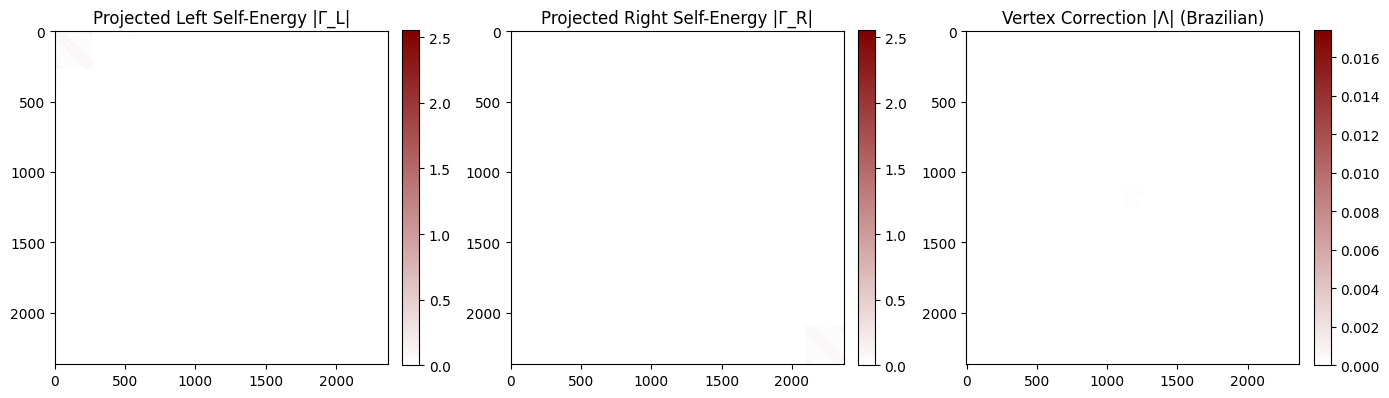

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(14, 8))

# --- Row 1 ---
im0 = axes[0].imshow(np.abs(gamma_L), cmap=maroon_cmap)
axes[0].set_title("Projected Left Self-Energy |Γ_L|")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(np.abs(gamma_R), cmap=maroon_cmap)
axes[1].set_title("Projected Right Self-Energy |Γ_R|")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im4 = axes[2].imshow(np.abs(lambda_corr_brazilian), cmap=maroon_cmap)
axes[2].set_title("Vertex Correction |Λ| (Brazilian)")
plt.colorbar(im4, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


### Now need to transform self-energy from LO to MO basis